## OBA Algorithm Demo

In [81]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import cv2

## we extract ORB feature points

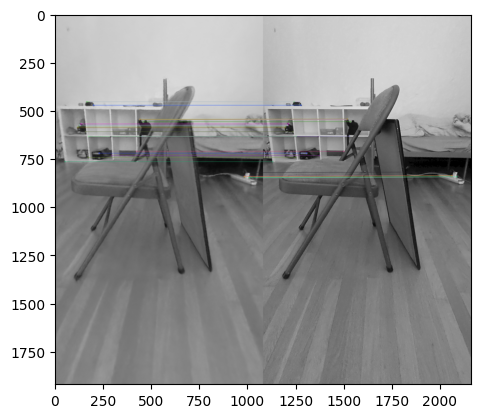

(<matplotlib.image.AxesImage at 0x7fe3ffc0a730>, None)

In [4]:
import cv2
from matplotlib import pyplot as plt

number_of_match = 30

# Load images
image_one_path = "/home/nerf-bridge/Desktop/OBA/experiment_images/image_render"  
image_two_path = "/home/nerf-bridge/Desktop/OBA/experiment_images/image_GT"  
img1 = cv2.imread(image_one_path, 0)  # Image 1 
img2 = cv2.imread(image_two_path, 0)  # Image 2

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in ascending order of distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 10 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:number_of_match], None, flags=2)

# Display the image
plt.imshow(img3), plt.show()

# Save the image
# cv2.imwrite('matched_features_bulldozer.jpg', img3)

## Extract SIFT feature points 

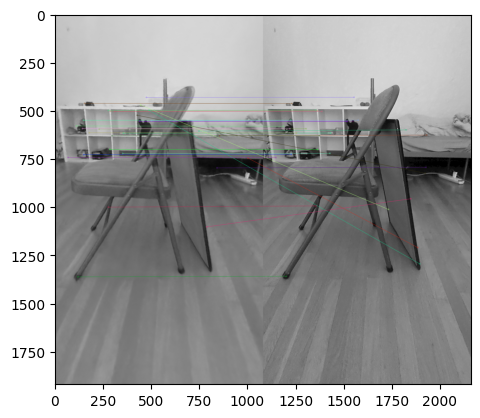

(<matplotlib.image.AxesImage at 0x7fe3ffbc00d0>, None)

In [5]:
import cv2
from matplotlib import pyplot as plt

number_of_match = 30

# Load images 
image_one_path = "/home/nerf-bridge/Desktop/OBA/experiment_images/image_render" 
image_two_path = "/home/nerf-bridge/Desktop/OBA/experiment_images/image_GT"  
img1 = cv2.imread(image_one_path, 0)  # Image 1 
img2 = cv2.imread(image_two_path, 0)  # Image 2

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in ascending order of distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 50 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:number_of_match], None, flags=2)

# Display the image
plt.imshow(img3), plt.show()

# Save the image
# cv2.imwrite('matched_features.jpg', img3)


## Get the distance for each match point on synthesized image

In [97]:

matched_points_img2 = [kp2[match.trainIdx].pt for match in matches[:number_of_match]]

print(len(matched_points_img2))
distance_for_each_point = []

for point in matched_points_img2:
    x_coord = int(round(point[0]))
    y_coord = int(round(point[1]))
    distance = min_loss_depth_field[x_coord, y_coord]
    distance_for_each_point.append(distance)

25


## Convert each match point to world frame 3d point

In [98]:
def get_3d_coordinates(x, y, d, intrinsics, tform_cam2world):
    # Create a vector for the image point with the depth
    # Note: the pixel coordinates must be normalized by subtracting the principal point and dividing by the focal length
    img_point = np.array([(x - intrinsics[0, 2]) / intrinsics[0, 0], 
                          (y - intrinsics[1, 2]) / intrinsics[1, 1], 
                          1.0]) * d

    # Convert the image point to homogeneous coordinates
    img_point_homogeneous = np.append(img_point, 1)

    # Multiply the transformation matrix by the image point to get the 3D point
    point_3d = np.dot(tform_cam2world, img_point_homogeneous)

    # Convert the 3D point back to non-homogeneous coordinates
    point_3d = point_3d / point_3d[3]

    return point_3d

In [99]:
focal_length = float(data["focal"])
intrinsics = np.array([[focal_length, 0, width * .5], [0, focal_length, width * .5], [0, 0, 1]])
tform_cam2world = testpose.detach().cpu().numpy()
point_3d_list = []

for i in range(number_of_match):
    point = matched_points_img2[i]
    x_coord = int(round(point[0]))
    y_coord = int(round(point[1]))
    distance = distance_for_each_point[i]
    point_3d = get_3d_coordinates(x_coord, y_coord, distance, intrinsics, tform_cam2world)
    point_3d_list.append(point_3d[0:3])

## Batch Adjustment

In [100]:
from scipy.optimize import least_squares

points_2d = np.array(matched_points_img2)
points_3d = np.array(point_3d_list)

In [101]:
import cv2
import numpy as np

# convert tform_cam2world to a 9d vector representing pose
def convert_to_true_params(tform_cam2world, x0, y0, f):
    # Extract the rotation and translation from the transformation matrix
    R_world2cam = tform_cam2world[:3, :3]
    T_world2cam = tform_cam2world[:3, 3]

    # Convert the rotation matrix to a rotation vector
    rotation_vector, _ = cv2.Rodrigues(R_world2cam)

    # Construct the true_params vector
    true_params = np.concatenate(([x0, y0, f], rotation_vector.flatten(), T_world2cam.flatten()), dtype=np.float64)

    return true_params

In [102]:
# Convert to true_params format
initial_estimation = convert_to_true_params(tform_cam2world, width * .5, width * .5, focal_length)
print(initial_estimation)

# Define function to transform 3D points to 2D
def project(points, params):
    x0, y0, f = params[:3]
    rotation_vector = params[3:6].astype(np.float64)  # Ensure rotation vector is float64
    translation_vector = params[6:]

    R, _ = cv2.Rodrigues(rotation_vector)
    projected_points = np.dot(points, R.T) + translation_vector
    projected_points = projected_points[:, :2] / projected_points[:, 2, np.newaxis]
    projected_points *= f
    projected_points[:, 0] += x0
    projected_points[:, 1] += y0
    return projected_points

# Define reprojection error
def fun(params, n, m, points_2d, points_3d):
    projected_points = project(points_3d, params)
    return (projected_points - points_2d).ravel()

# Use the least_squares function to solve the bundle adjustment problem
res = least_squares(fun, initial_estimation, args=(2, 3, points_2d, points_3d))

# Print the true parameters and the ones estimated by bundle adjustment
# print('True pose: ', true_params)
print('#######################################')
print('initial pose: ', initial_estimation)
print('#######################################')
print('Estimated pose: ', res.x)

[ 50.          50.         138.8888789    0.22674397   1.21468854
   2.52305841   1.13680696   2.93888736   2.51408243]
#######################################
initial pose:  [ 50.          50.         138.8888789    0.22674397   1.21468854
   2.52305841   1.13680696   2.93888736   2.51408243]
#######################################
Estimated pose:  [ 5.30449070e+01  6.34031457e+01  1.33590411e+02  2.14087412e-01
  1.35904142e+00  3.18686448e+00  1.04286597e-01  3.71172873e-01
 -4.12517353e+00]


## Another method

In [103]:
import numpy as np
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R

def project(point_3d, pose):
    # pose is a 4x4 transformation matrix
    # Convert the 3D point to homogeneous coordinates
    point_3d_homogeneous = np.append(point_3d, 1)
    
    # Multiply the transformation matrix by the 3D point to get the projected point
    projected_point = np.dot(pose, point_3d_homogeneous)
    
    # Convert the projected point back to non-homogeneous coordinates
    projected_point = projected_point / projected_point[3]
    
    return projected_point[:2]

def fun(pose_params, points_2d, points_3d):
    # pose_params is a 1D array that contains the rotation as a quaternion and the translation
    rotation_quaternion = pose_params[:4]
    translation = pose_params[4:]
    
    # Convert the rotation from a quaternion to a matrix
    rotation_matrix = R.from_quat(rotation_quaternion).as_matrix()
    
    # Construct the pose matrix
    pose = np.eye(4)
    pose[:3, :3] = rotation_matrix
    pose[:3, 3] = translation
    
    # Project the 3D points using the pose matrix
    projected_points = np.array([project(p, pose) for p in points_3d])
    
    # Return the difference between the projected and observed 2D points
    return (projected_points - points_2d).ravel()

# Assume you have some 3D points and their corresponding 2D points
points_3d = np.random.rand(25, 3)
points_2d = np.random.rand(25, 2)

# You know the initial pose of the camera (identity transformation)
initial_pose = tform_cam2world

# Convert the rotation part of the pose to a quaternion
initial_rotation_quaternion = R.from_matrix(initial_pose[:3, :3]).as_quat()

# Get the translation part of the pose
initial_translation = initial_pose[:3, 3]

# Concatenate the rotation and translation into a 1D array
initial_pose_params = np.concatenate([initial_rotation_quaternion, initial_translation])

# Use the least_squares function to solve the optimization problem
res = least_squares(fun, initial_pose_params, args=(points_2d, points_3d))

# Print the initial and estimated poses
print('Initial pose:')
print(initial_pose)

estimated_rotation = R.from_quat(res.x[:4]).as_matrix()
estimated_translation = res.x[4:]
estimated_pose = np.eye(4)
estimated_pose[:3, :3] = estimated_rotation
estimated_pose[:3, 3] = estimated_translation

print('Estimated pose:')
print(estimated_pose)


Initial pose:
[[-0.93265635 -0.22499779  0.2820071   1.136807  ]
 [ 0.36076587 -0.581667    0.7290482   2.9388874 ]
 [ 0.          0.78169     0.62366706  2.5140824 ]
 [ 0.          0.          0.          1.        ]]
Estimated pose:
[[-0.50633098  0.7701018   0.38803628  0.09887322]
 [-0.76311447 -0.60970616  0.21427717  1.05652361]
 [ 0.40160334 -0.18762093  0.89638895  2.51408243]
 [ 0.          0.          0.          1.        ]]
